In [2]:
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- M2SL: https://fred.stlouisfed.org/series/M2SL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [93]:
"""

# Generate a date range from January 1950 to the present
date_range = date_range = pd.date_range(start='1950', end='2024', freq='M')

# Create Original data frame, wich Date, Year, Month columns
df_origin = pd.DataFrame({'Date': date_range})
df_origin['Year'] = df_origin['Date'].dt.year
df_origin['Month'] = df_origin['Date'].dt.month


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left')


# Download S&P500 data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()
# Add the close prices of S&P500 on each month
df_origin['SP500'] = sp500[sp500['Date'] >= '1950-01-31']['Close']

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

[*********************100%***********************]  1 of 1 completed


,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1950-01-31,1950,1,NaN,23.51,NaN,NaN,NaN,6.5,17.049999
1,1950-02-28,1950,2,NaN,23.61,NaN,NaN,NaN,6.4,17.219999
2,1950-03-31,1950,3,NaN,23.64,NaN,NaN,NaN,6.3,17.290001
3,1950-04-30,1950,4,NaN,23.65,NaN,NaN,NaN,5.8,17.959999
4,1950-05-31,1950,5,NaN,23.77,NaN,NaN,NaN,5.5,18.780001


In [212]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1950-01-31,1950,1,NaN,23.51,NaN,NaN,NaN,6.5,17.049999
1,1950-02-28,1950,2,NaN,23.61,NaN,NaN,NaN,6.4,17.219999
2,1950-03-31,1950,3,NaN,23.64,NaN,NaN,NaN,6.3,17.290001
3,1950-04-30,1950,4,NaN,23.65,NaN,NaN,NaN,5.8,17.959999
4,1950-05-31,1950,5,NaN,23.77,NaN,NaN,NaN,5.5,18.780001


# Data Clearning & Modification

In [213]:
# dropping rows based on any missing data
df = df_origin.dropna()

# groupby dataframe based on "Year" and check the count
df.groupby('Year').count()[['Date']]

,Date
Year,
1972,4
1973,4
1974,4
1975,4
1976,4
1977,4
1978,12
1979,12
1980,12


In [214]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1978-01-31,1978,1,7.94,62.7,83.7,43.7471,795.0,6.4,89.250000
1,1978-02-28,1978,2,8.04,63.0,84.3,43.9139,791.0,6.3,87.040001
2,1978-03-31,1978,3,8.15,63.4,78.8,44.6899,814.0,6.3,89.209999
3,1978-04-30,1978,4,8.24,63.9,81.6,45.3905,864.0,6.1,96.830002
4,1978-05-31,1978,5,8.42,64.5,82.9,45.6235,857.0,6.0,97.239998


In [219]:
# Create categorical data;
#  whether the S&P500 rises (1) or falls(0) compared to a year ago
cat_values = (df['SP500'] > df['SP500'].shift(12))
cat_values[:12] = None
df['SP500_RISE'] = cat_values

# Changes to %YoY
chg_YoY = ['CPI', 'CSENT', 'IPM', 'HOUSE', 'SP500']
df.loc[:, chg_YoY] = df[chg_YoY].pct_change(12) * 100

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500,SP500_RISE
0,1979-01-31,1979,1,8.95,9.250399,-13.859020,7.862464,-5.157233,5.9,11.966387,True
1,1979-02-28,1979,2,9.17,9.841270,-12.336892,7.786828,-8.596713,5.9,10.615806,True
2,1979-03-31,1979,3,9.11,10.252366,-13.197970,6.418676,-2.579853,5.8,13.877365,True
3,1979-04-30,1979,4,9.35,10.485133,-19.117647,2.997984,-13.425926,5.8,5.091398,True
4,1979-05-31,1979,5,9.06,10.697674,-17.852835,3.917937,-15.169195,5.6,1.892230,True


In [221]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(888, 10)  ->  (536, 11)

Total Missing Valies:
830  ->  0


In [222]:
# basic statistics (original)
features = ['SP500', 'MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']
df_origin[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,886.000000,742.000000,885.000000,640.000000,620.000000,728.000000,885.000000
mean,776.946704,5.874515,122.272904,85.612031,74.204909,655.686813,5.733672
std,1034.378161,2.992464,83.730383,12.870315,23.716954,208.464177,1.711406
min,17.049999,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000
25%,88.822500,3.852500,34.700000,76.100000,50.362625,515.000000,4.400000
50%,248.285004,5.630000,110.400000,89.300000,81.475050,628.000000,5.500000
75%,1211.747528,7.635000,193.600000,95.000000,98.332150,765.250000,6.800000
max,4766.180176,15.840000,307.481000,112.000000,106.420200,1389.000000,14.700000


In [223]:
# basic statistics (current)
df[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,10.036841,5.773451,3.521761,0.397950,1.891457,1.482379,6.118843
std,15.923973,3.392282,2.760574,13.495788,4.906403,19.957188,1.779992
min,-44.756241,0.550000,-1.958761,-41.520468,-19.513084,-50.534759,3.400000
25%,2.039978,2.937500,1.896680,-6.602810,-0.218039,-10.908385,4.800000
50%,11.647982,5.070000,2.842673,0.250135,2.357958,2.704228,5.700000
75%,19.648005,8.020000,4.129461,6.696820,4.726355,13.571031,7.200000
max,53.714506,15.840000,14.592275,47.582205,20.819818,88.200590,14.700000


# Data Observation

### Correlation Matrix

In [224]:
# correlation Matrix
df[features].corr()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
SP500,1.000000,0.040578,-0.020042,0.418819,0.398670,0.378325,0.026339
MY10Y,0.040578,1.000000,0.592328,0.132322,0.159296,-0.105760,0.280852
CPI,-0.020042,0.592328,1.000000,-0.230014,0.023860,-0.362648,0.008336
CSENT,0.418819,0.132322,-0.230014,1.000000,0.300586,0.402723,0.177823
IPM,0.398670,0.159296,0.023860,0.300586,1.000000,0.136040,-0.239208
HOUSE,0.378325,-0.105760,-0.362648,0.402723,0.136040,1.000000,0.142735
UNEMP,0.026339,0.280852,0.008336,0.177823,-0.239208,0.142735,1.000000


### Feature Reduction

In [225]:
# create a new feature and insert it 
df.insert(loc=9, column='LRIR', value=df['MY10Y'] - df['CPI'])

# drop MY10Y and CPI
df.drop(['MY10Y', 'CPI'], axis=1, inplace=True)

# show new dimension
print("New Dimension: ", df.shape)

# show new correlation matrix
features = ['SP500','CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
df[features].corr()

New Dimension:  (536, 10)


,SP500,CSENT,IPM,HOUSE,UNEMP,LRIR
SP500,1.000000,0.418819,0.398670,0.378325,0.026339,0.068081
CSENT,0.418819,1.000000,0.300586,0.402723,0.177823,0.382374
IPM,0.398670,0.300586,1.000000,0.136040,-0.239208,0.167405
HOUSE,0.378325,0.402723,0.136040,1.000000,0.142735,0.226617
UNEMP,0.026339,0.177823,-0.239208,0.142735,1.000000,0.327998
LRIR,0.068081,0.382374,0.167405,0.226617,0.327998,1.000000


### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


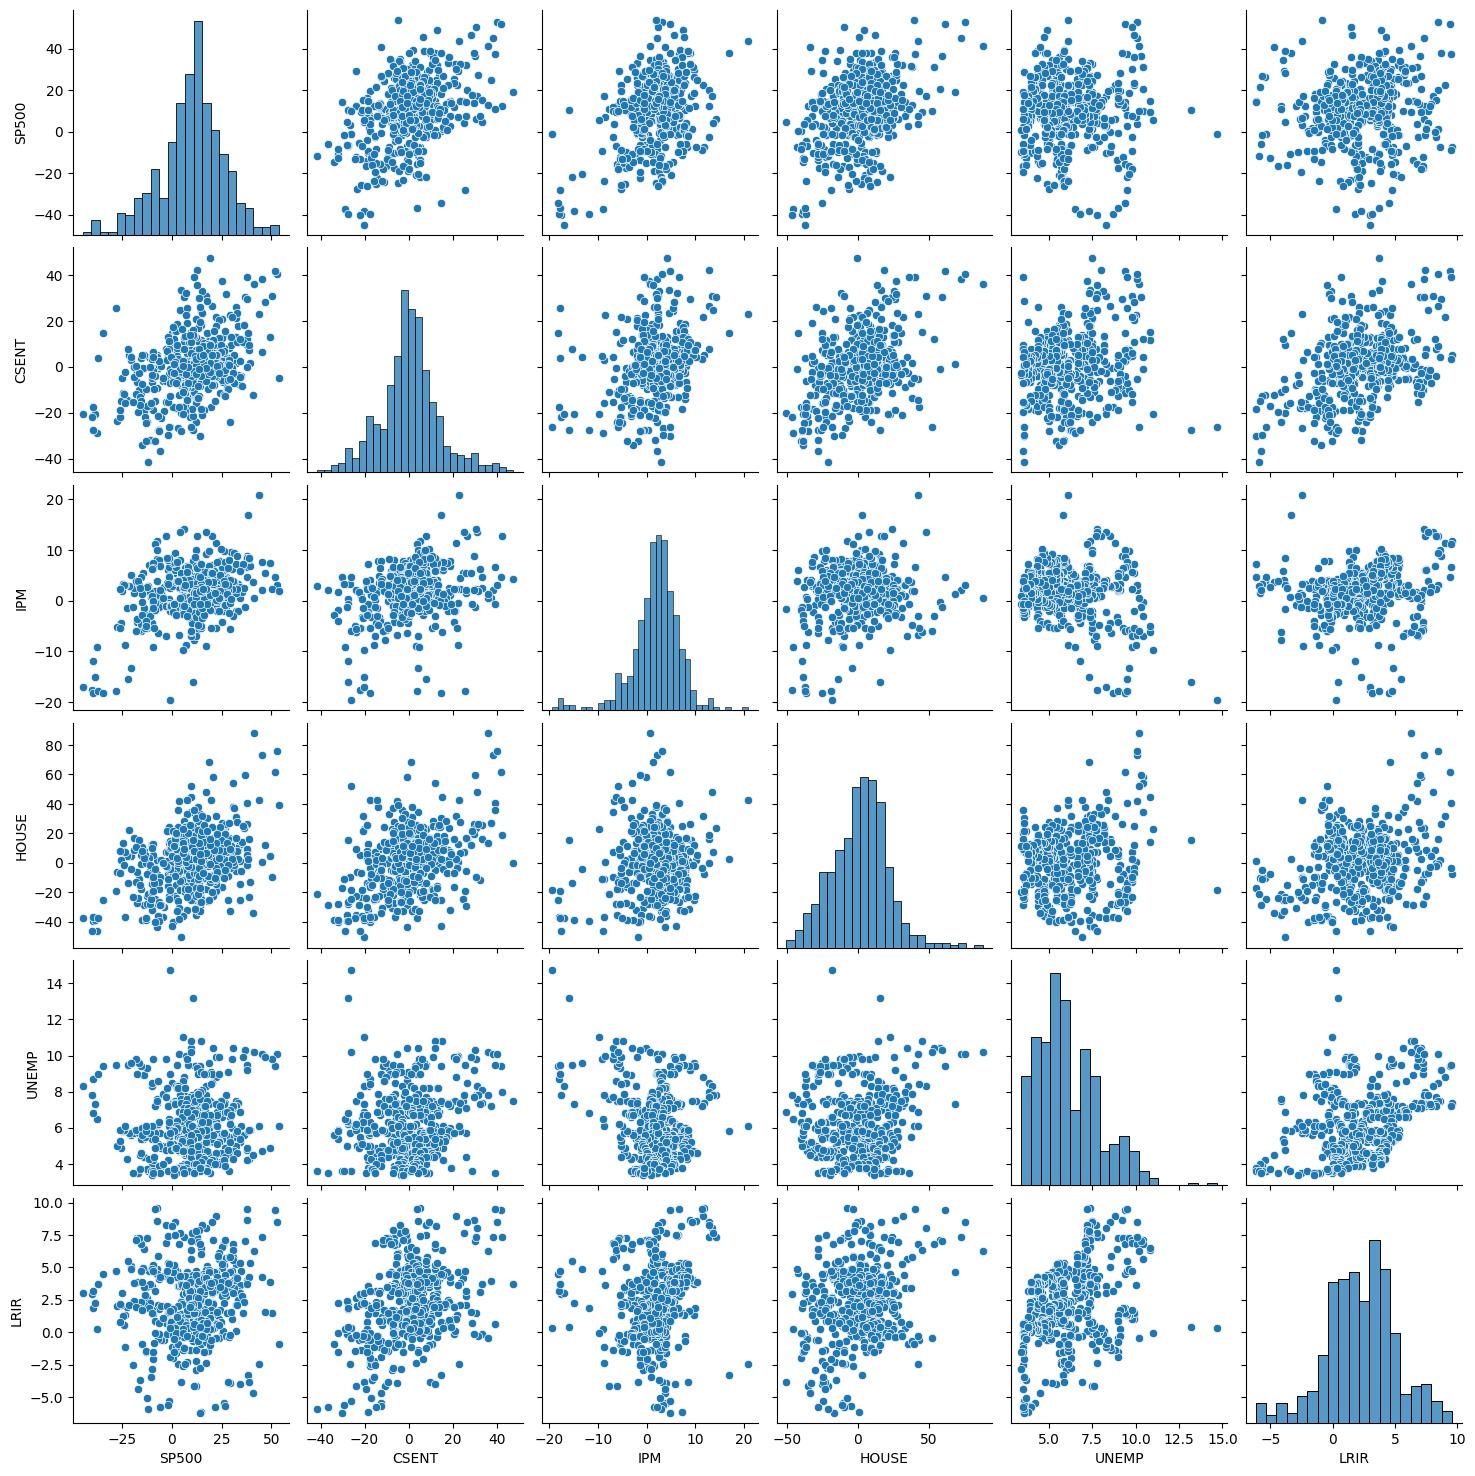

In [227]:
# check correlation 
sns.pairplot(df[features])

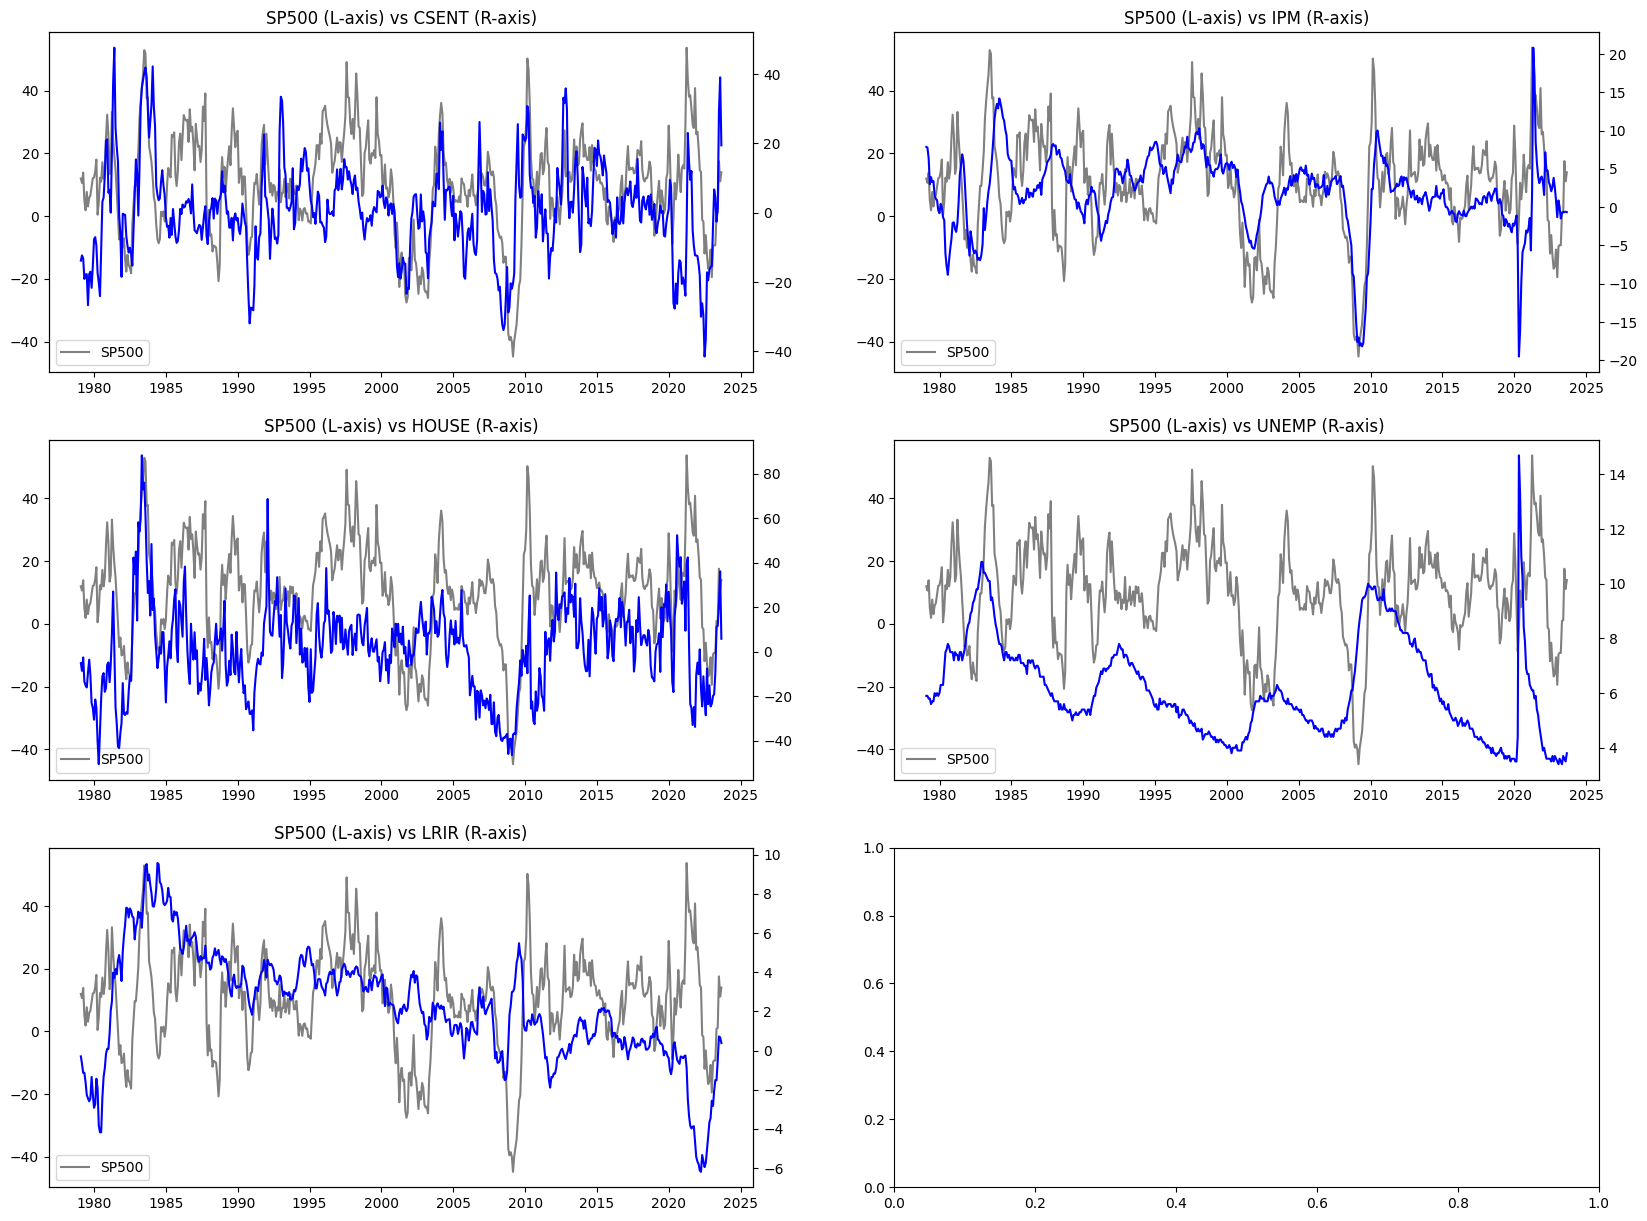

In [228]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2
#['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))

for idx, d in enumerate(features[1:]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"SP500 (L-axis) vs {d} (R-axis)")
    ax[i][j].legend()


Text(0.5, 0.98, 'Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

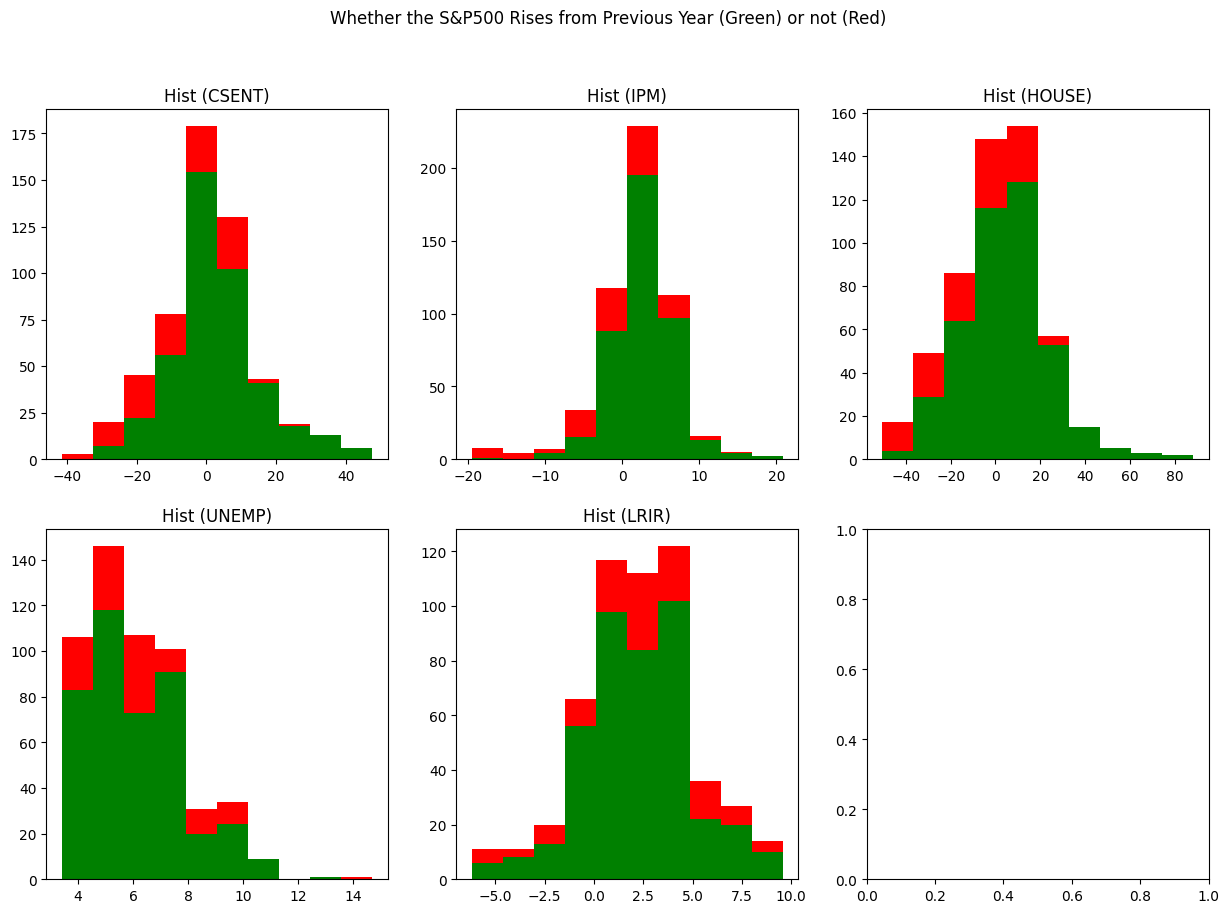

In [229]:
# Observing the economic indicators and each categorical variables

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, data in enumerate(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']):
    i1, i2 = i // 3, i % 3
    rise = df[df['SP500_RISE'] == 1.0][data]
    fall = df[df['SP500_RISE'] == 0.0][data]
    ax[i1][i2].hist([rise, fall], color=['green', 'red'], stacked=True)
    ax[i1][i2].set_title(f'Hist ({data})')

plt.suptitle('Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

# Dataset Creation

- All data except for 'UNEMP' are converted to %YoY. 
- There are 12 datasets derived from the original one.
    - Three types of future performances (row shifts) will be applied to all economic indicators; 1-, 2-, and 3-months
    - Four types of moving averages will be applied to every data; 0-, 3-, 6-, and 12-months

In [ ]:
# create dictionary of dataframe
df_dict = {}
# define column names for each x and y from "df"
col_Y = 'SP500_%YoY'
col_X = ['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']

# row shifts
for s in [1,2,3]:
    # copy current df
    new_df = df.copy()
    # shifting row(s)
    new_df = new_df[col_X].shift(s)

    # different moving average
    for ma in [0, 3, 6, 12]:
        pass

In [ ]:
focus_cols.remove('SP500_%YoY')
focus_cols

['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']

In [ ]:
test = df[['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']].shift(1)

test

,MY10Y_%YoY,CPI_%YoY,CSENT_%YoY,IPM_%YoY,HOUSE_%YoY,UNEMP
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.072973,0.068143,-0.037931,0.068292,-0.036364,6.4
2,0.079195,0.062395,-0.032147,0.052995,-0.057211,6.3
3,0.098383,0.063758,-0.095293,0.056017,-0.066514,6.3
4,0.106040,0.065000,-0.063146,0.061632,0.081352,6.1
...,...,...,...,...,...,...
543,0.500000,0.049869,0.043771,-0.014847,-0.094767,3.5
544,0.190311,0.049572,-0.026074,-0.007125,0.111293,3.4
545,0.277193,0.041288,0.013699,-0.006166,0.116352,3.7
546,0.278523,0.030920,0.288000,-0.006616,0.214920,3.6


# Model Creation

# Test

,Date,Year,Month,SP500,CSENT,IPM,HOUSE,UNEMP,LRIR
531,2023-04,2023,4,1.153883,-2.607362,-0.712492,11.129296,3.4,-1.517192
532,2023-05,2023,5,17.567590,1.369863,-0.616579,11.635220,3.7,-0.488844
533,2023-06,2023,6,11.105029,28.800000,-0.661627,21.492007,3.6,0.717997
534,2023-07,2023,7,13.973708,39.029126,-0.592349,36.095764,3.5,0.670925
535,2023-08,2023,8,NaN,19.415808,-0.656313,5.799373,3.8,0.382496


In [82]:
x_cols = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

In [92]:
df_shift = df.copy()
df_shift['SP500'] = df['SP500'].shift(-3)
df_shift.tail()

,Date,Year,Month,SP500,CSENT,IPM,HOUSE,UNEMP,LRIR
531,2023-04,2023,4,11.105029,-2.607362,-0.712492,11.129296,3.4,-1.517192
532,2023-05,2023,5,13.973708,1.369863,-0.616579,11.635220,3.7,-0.488844
533,2023-06,2023,6,NaN,28.800000,-0.661627,21.492007,3.6,0.717997
534,2023-07,2023,7,NaN,39.029126,-0.592349,36.095764,3.5,0.670925
535,2023-08,2023,8,NaN,19.415808,-0.656313,5.799373,3.8,0.382496


In [268]:
from sklearn.linear_model import LinearRegression

# predicted %YoY growths after each month based on the last 10 years data
date = df['Date'].iloc[120:].values
est_growth = {'1M': [np.nan], '2M': [np.nan]*2, '3M': [np.nan]*3}
future = {'1M': [], '2M': [], '3M': []}
# test data index

for m in [1,2,3]:
    # shift data for each month
    df_shift = df.copy()
    df_shift['SP500'] = df['SP500'].shift(-m)
    # create train and test data
    for i in range(120, len(df)-m):
        # define start index
        s = i - 120
        train = df_shift.iloc[s:i]
        test = df_shift.iloc[i:i+1]

        # define model
        model = LinearRegression()
        # fit the data
        model.fit(train[x_cols], train['SP500'])
        # get and predicted value and store it to dict
        est_growth[f'{m}M'] += list(model.predict(test[x_cols]))
    
    # add the rest of feature(s)
    future[f'{m}M'] += list(model.predict(df_shift.iloc[-m:][x_cols])) 

In [231]:
result_df = df[['Date', 'SP500']].iloc[120:].reset_index(drop=True)
# add predicted growth
for k in est_growth.keys():
    result_df[f"Est_{k}_Ago"] = est_growth[k]
result_df.head()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
0,1989-01,15.715561,NaN,NaN,NaN
1,1989-02,7.856014,24.660302,NaN,NaN
2,1989-03,13.897786,12.531227,22.899435,NaN
3,1989-04,18.486217,9.114212,11.757725,22.306831
4,1989-05,22.261209,11.153234,8.972035,11.393356


In [232]:
result_df.tail()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
411,2023-04,0.908772,2.687153,3.438394,2.489983
412,2023-05,1.153883,5.561697,2.336005,4.000293
413,2023-06,17.567590,6.732435,5.110040,3.151268
414,2023-07,11.105029,11.939503,7.009820,5.578984
415,2023-08,13.973708,15.989454,11.825849,7.337735


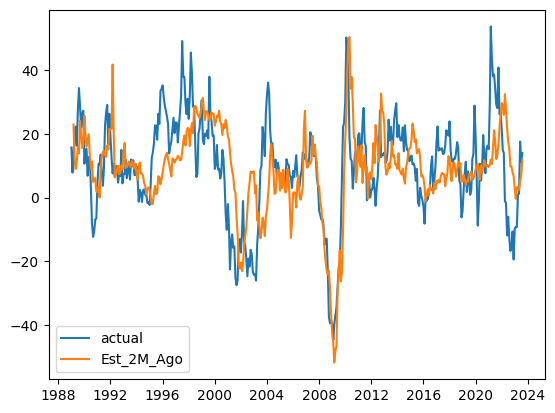

In [275]:
plt.plot(pd.to_datetime(result_df['Date']), result_df['SP500'], label='actual')
plt.plot(pd.to_datetime(result_df['Date']), result_df['Est_2M_Ago'], label='Est_2M_Ago')
plt.legend()

In [271]:
future

{'1M': [8.674979625958029],
 '2M': [15.35483201095332, 8.707772307491057],
 '3M': [13.59716455647952, 17.544255000982595, 10.17739639106059]}

In [259]:
for a, b in zip([3585.620117, 3871.979980, 4080.110107], future):
    growth = (b/100) + 1
    print(a*growth)


3896.671931614002
4209.143180450038
4495.359085781116
